# Practica A2 AAMD


## 1. Lectura de les dades
Primer de tot, llegirem les dades dels nostres arxius TXT i els guardarem en dataframes.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import math
import seaborn as sns


df_real_og = pd.read_csv('data/A2-real.txt', sep=';')
df_synthetic_og = pd.read_csv('data/A2-synthetic.txt', sep=',')

datasets = {
    "real": df_real_og,
    "synthetic": df_synthetic_og
}

df_synthetic_og.head()

,x1,x2,x3,x4,class
0,-0.031676,-9.912054,-0.579436,-1.044239,1
1,0.002526,6.172456,3.288339,-1.006427,5
2,0.183123,-0.387841,6.236470,-1.691491,2
3,-0.042262,-1.996272,-1.655302,-2.995311,1
4,-0.062811,-0.417072,6.657475,-3.633134,4


## 2. Pre-processament de les dades
En aquest punt, ja que ja s'han tractat els dos conjunts de dades per a eliminar outliers, dades no físiques i dades incomplertes, només treurem dels nostres dataframes les columnes que no necessitem. En el cas de les dades reals, seràn les columnes de "Class" i "Location". En el cas de les dades sintètiques, serà la columna "class".

In [27]:
df_real = df_real_og.drop(columns=["Class", "Location"])
df_synthetic = df_synthetic_og.drop(columns=["class"])

df_synthetic.head()

# Escalar les dades per a que totes totes les variables tinguin el mateix pes 
# (si no, si una variable té un rang numèric més gran, dominarà la variància encara que no sigui més important)
scaler = StandardScaler()
df_real_scaled = scaler.fit_transform(df_real)
df_syn_scaled = scaler.fit_transform(df_synthetic)


## 3. Aplicar tècniques d’aprenentatge no supervisat
### • Principal Component Analysis (PCA)
Per aquesta tècnica d'aprenentatge haurem de trobar i representar gràficament la projecció PCA en dues dimensions, utilitzant un color diferent per a cada classe, i fer un “scree plot” de la variància acumulada.

PCA és una tècnica que redueix la dimensionalitat de les dades, i projecta les dades originals a noves variables "components principals" que expliquen la major variància possible.

#### Dades reals

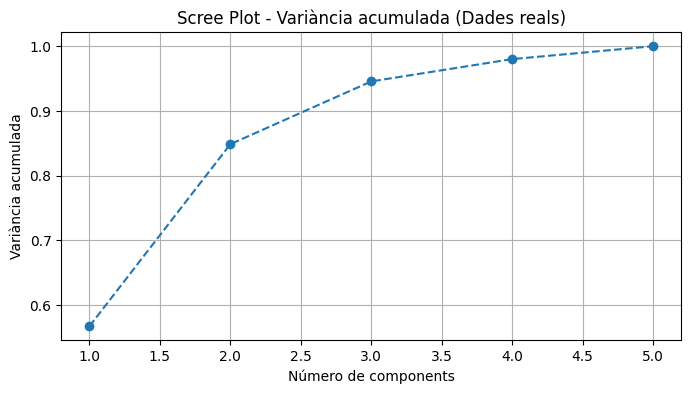

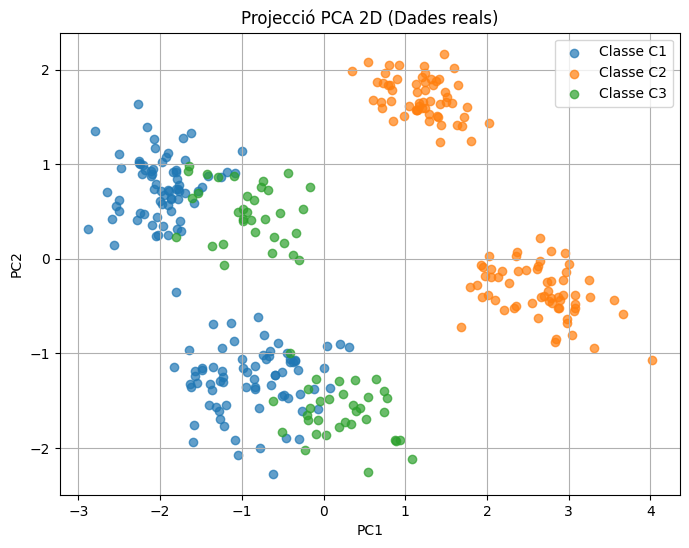

In [24]:
x_real = df_real_scaled.copy()

# Classe i localització de les dades reals per després fer la visualització de dades
y_real = df_real_og['Class']
loc_real = df_real_og['Location']

# Apliquem PCA
pca = PCA()
x_real_pca = pca.fit_transform(x_real)

# Scree plot de la variància acumulada
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Scree Plot - Variància acumulada (Dades reals)')
plt.xlabel('Número de components')
plt.ylabel('Variància acumulada')
plt.grid(True)
plt.show()

# 6. Visualización PCA 2D coloreando por clase
plt.figure(figsize=(8, 6))
for clase in sorted(y_real.unique()):
    idx = y_real == clase
    plt.scatter(x_real_pca[idx, 0], x_real_pca[idx, 1], label=f'Classe {clase}', alpha=0.7)

plt.title('Projecció PCA 2D (Dades reals)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

Com podem observar al Scree Plot de les dades reals, cada component captura la màxima variància possible en les dades, augmentant la variància acumulada. Això és degut a que el PCA construeix cada component principal de forma que maximiza la variança no explicada pels components anterior, per tant a cada component que es suma, sempre aportarà informació adicional (encada que a menor mesura).

En la representació 2D de les dades reals, es projecten les dades sobre els primers components principals (PC1 i PC2), que capturen la major part de la variança del conjunt original. Hem utilitzat la columna "classe" de les dades reals (no utilitzada per l'aprenentatge) per diferenciar amb colors els grups separats. 
A la classe 2, per exemple, es veu molt clarament com el PCA ha reduit la dimensionalitat mantenint una bona part de la estructura, però amb les classes 1 i 3 es veu que algunes dades es solapen entre elles. Això podria ser per similituds estructurals entre aquestes classes, o limitacions del mètode PCA.

#### Dades sintètiques

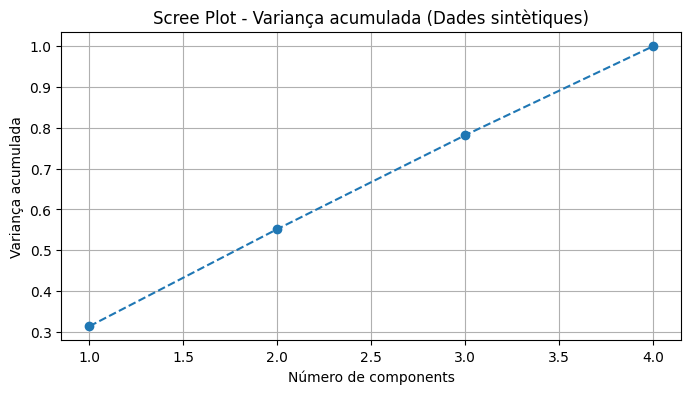

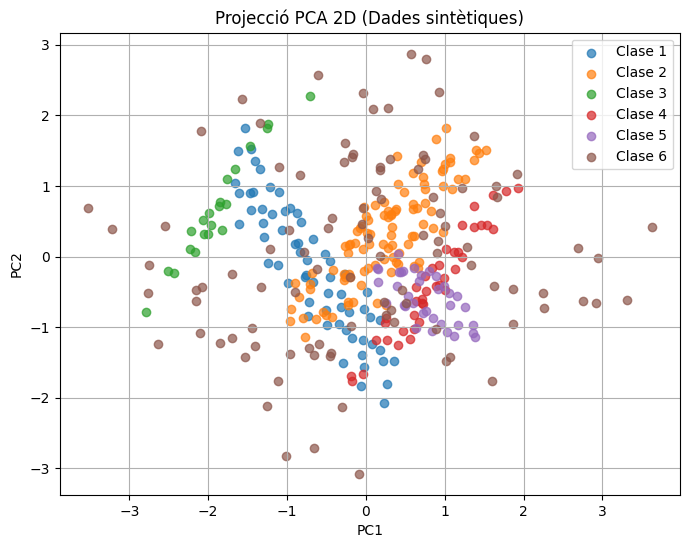

In [ ]:
x_synthetic = df_syn_scaled.copy()

# Classe per visualitzar
y_synthetic = df_synthetic_og['class']

# PCA
x_syn_pca = pca.fit_transform(x_synthetic)

# Scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Scree Plot - Variança acumulada (Dades sintètiques)')
plt.xlabel('Número de components')
plt.ylabel('Variança acumulada')
plt.grid(True)
plt.show()

# Visualització PCA 2D
plt.figure(figsize=(8, 6))
for clase in sorted(y_synthetic.unique()):
    idx = y_synthetic == clase
    plt.scatter(x_syn_pca[idx, 0], x_syn_pca[idx, 1], label=f'Clase {clase}', alpha=0.7)

plt.title('Projecció PCA 2D (Dades sintètiques)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()

En el cas de les dades sintètiques, observem que el Scree Plot és molt diferent a l'anterior. En aquesta ocasió, la gràfica resultant és una línia diagonal perfecta, el que significa que a cada component principal, s'ha aportat una quantitat similar d'informació. 

Aquesta irregularitat de les dades obtingudes també la podem observar a la gràfica 2D, en la qual es veu molt clarament a la classe 6 que no hi ha massa estructura ni uniformitat. A les altres 5 classes sí que es pot veure una mica més segmentada i correcta la classificació.

Aquests resultats són conseqüència de que algunes de les dades sintètiques poden estar poc correlacionades, de manera que no hi ha molts components que dominin clarament la variància total.

### • t-distributed Neighbor Stochastic Embedding (t-SNE)
Per aquest mètode també haurem de trobar i representar gràficament la projecció t-SNE en dues dimensions, utilitzant diferents valors dels paràmetres (perplexity).

Aquesta és una tècnica de reducció de dimensionalitat no lineal utilitzada principalment per la visualització de dades. Preserva l'estructura local de les dades al reduir-les a una dimensió menor (típicament 2D o 3D).


#### Dades reals

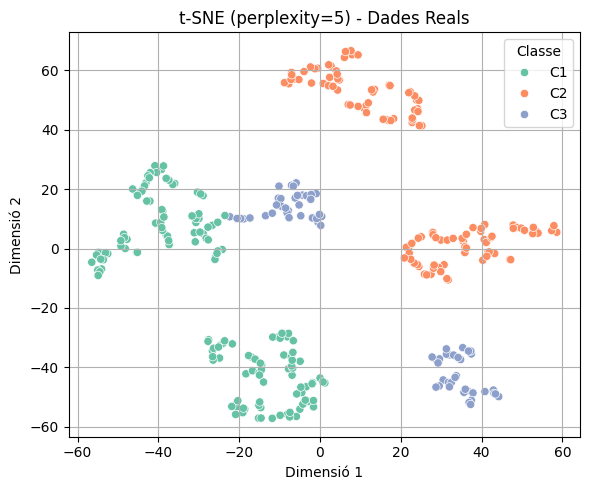

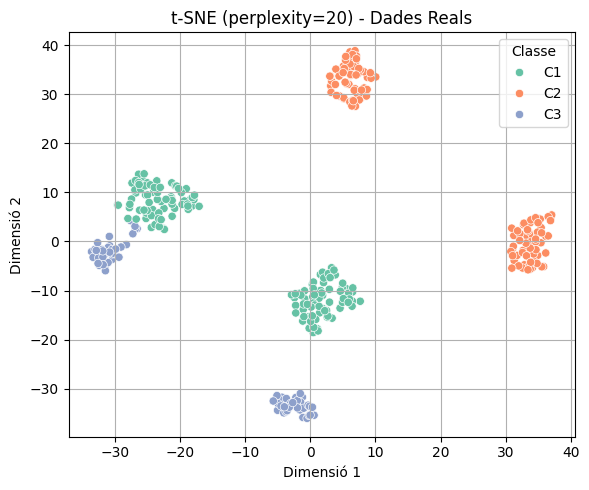

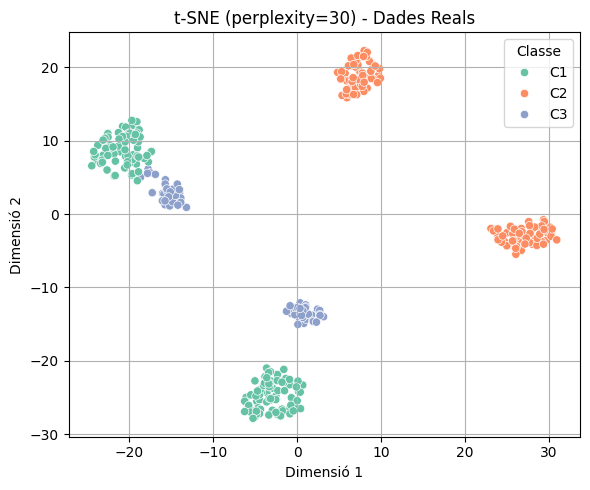

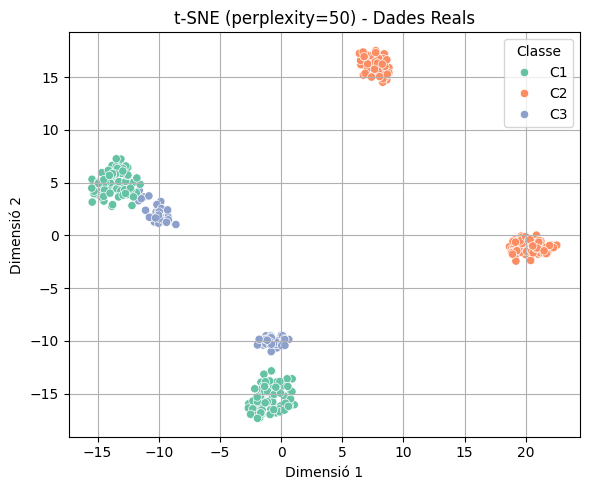

In [ ]:
for perplexity in [5, 20, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    x_tsne = tsne.fit_transform(x_real)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=y_real, palette='Set2')
    plt.title(f"t-SNE (perplexity={perplexity}) - Dades Reals")
    plt.xlabel("Dimensió 1")
    plt.ylabel("Dimensió 2")
    plt.legend(title="Classe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Per provar aquest mètode hem utilitzat diversos graus de perplexitat, i hem obtingut una gràfica per cada perplexitat. Els resultats mostren que, per a certs valors (com 30), les classes s'agrupen de forma molt clara i apareixen separacions visuals entre els grups, realitzant un treball bastant satisfactori. En canvi, amb valors de perplexitat baixos (com 5), les dades estàn una mica més esparcides i hi ha més soroll. 

#### Dades sintètiques

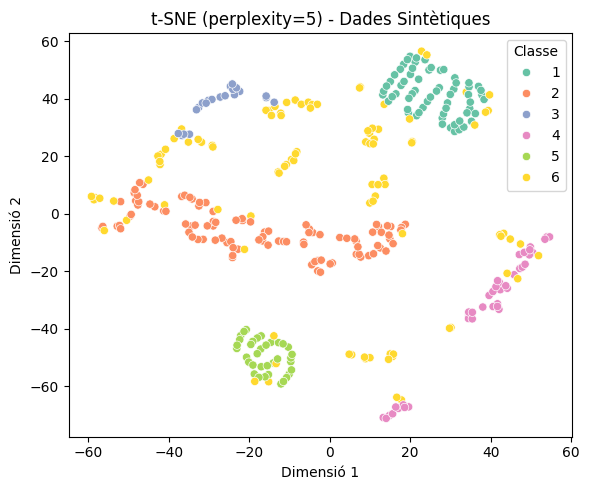

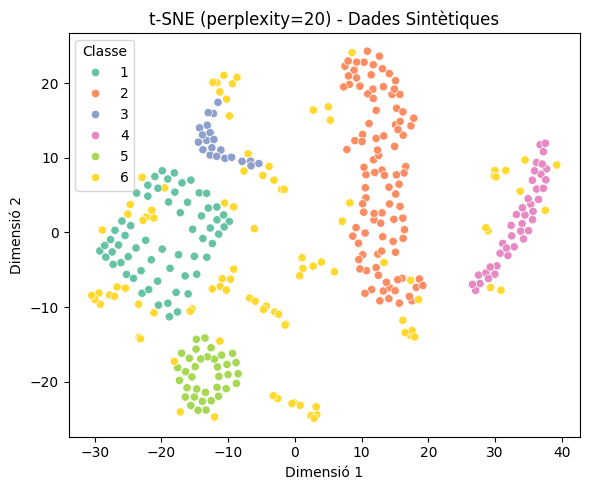

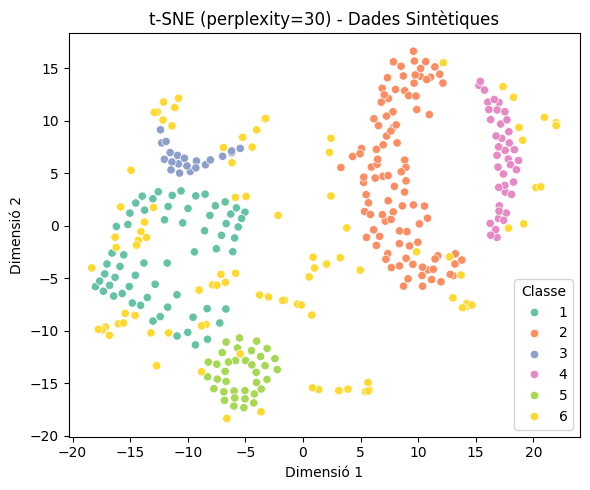

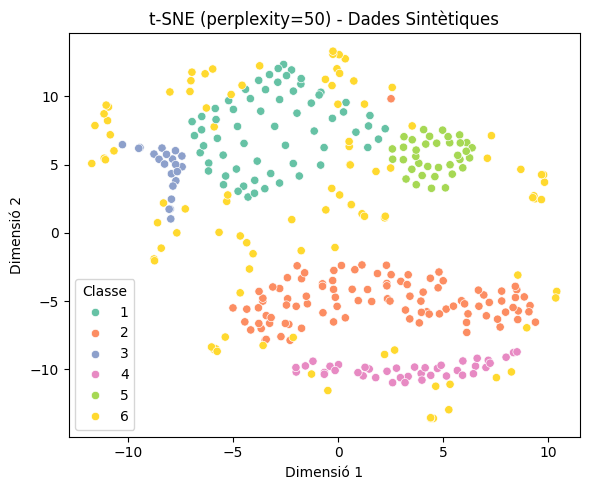

In [31]:
for perplexity in [5, 20, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    x_tsne = tsne.fit_transform(x_synthetic)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=x_tsne[:,0], y=x_tsne[:,1], hue=y_synthetic, palette='Set2')

    plt.title(f"t-SNE (perplexity={perplexity}) - Dades Sintètiques")
    plt.xlabel("Dimensió 1")
    plt.ylabel("Dimensió 2")
    plt.legend(title="Classe")
    plt.tight_layout()
    plt.show()


Per les dades sintètiques podem veure que els grups de cada classe queden molt més esparcits, per gran o petit que sigui el grau de perplexitat. Els resultats, una vegada més, són molt menys clars que en les dades reals, i sense les separacions que tenim amb colors, les dades serien il·legibles a la gràfica.

### • k-means
Per aquest mètode classificarem els patrons en k = 2, 3, ..., K (nosaltres farem fins K = 6) classes, i les compararem amb les classes reals. Per cada valor de k, farem un scatter plot de les dades utilitzant com a coordenades x i y les obtingudes amb PCA.

K-means és un algorisme d'aprenentatge automàtic no supervisat que busca iterativament minimitzar la distància entre els punts de dades. L'objectiu és trobar k clusters on cada punt de les dades pertanyi al clúster amb el centroide més proper. 

#### Dades reals

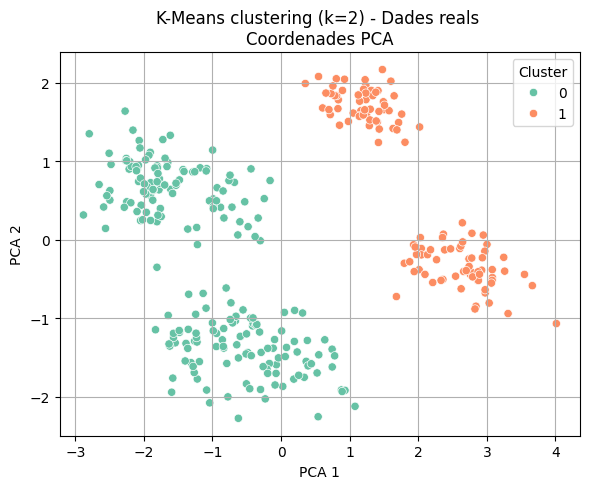

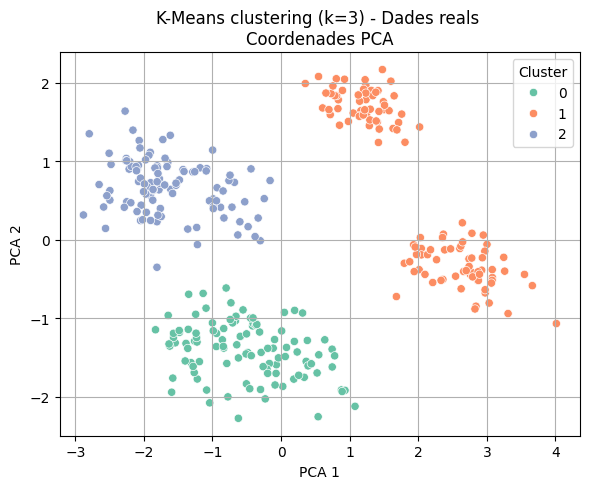

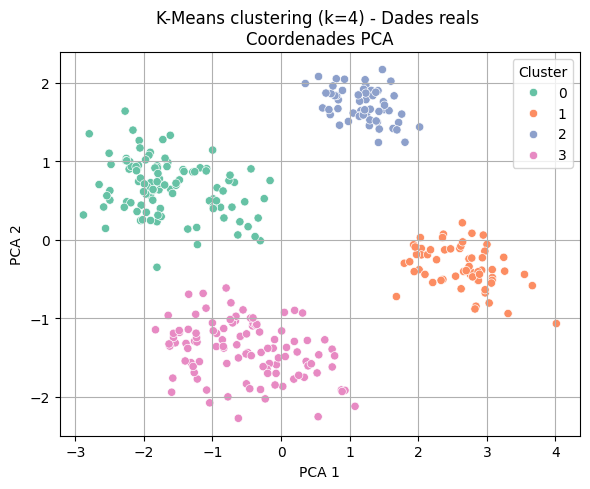

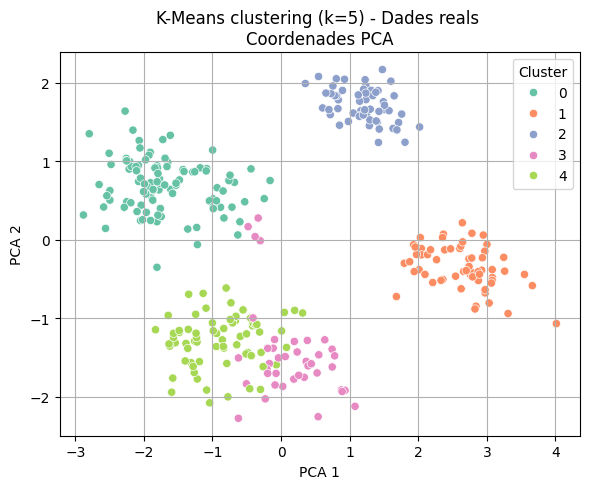

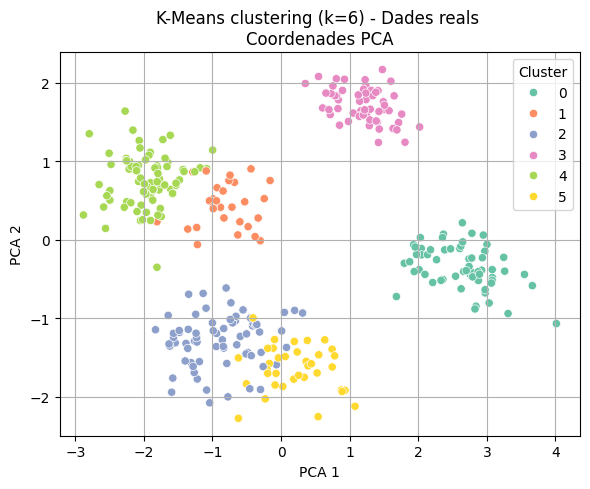

In [33]:
# Recalculem PCA
pca = PCA(n_components=2)
x_real_pca = pca.fit_transform(x_real)

# Probar amb k = 2 fins k = 6
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(x_real)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=x_real_pca[:, 0], y=x_real_pca[:, 1], hue=clusters, palette='Set2', legend="full")
    plt.title(f"K-Means clustering (k={k}) - Dades reals \nCoordenades PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Per les dades reals podem veure com, evidentment, més clusters o grups assignem, més separacions de grups hi haurà al scatter plot. Tot i això, quan fem la comparativa amb la projecció PCA en 2D de les dades reals que hem fet al primer apartat, veiem que quan assignem 3 clústers (nombre real de classes que hi ha en aquest conjunt de dades), l'assignació de classes no és la correcta. Això pot denotar que l'estructura de dades real no té una separació neta o que les variables no tenen prou capacitat discriminativa.

#### Dades sintètiques

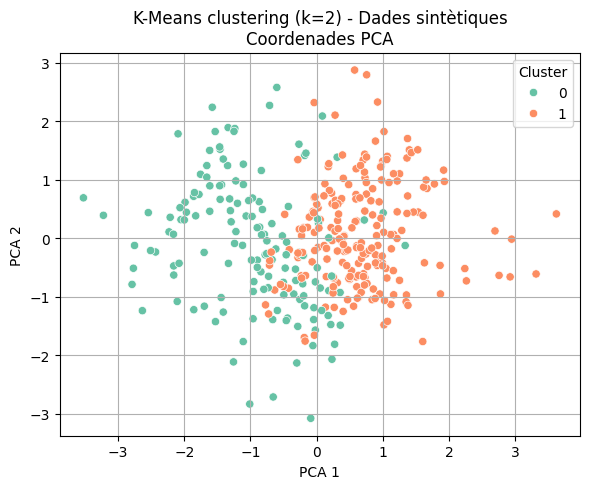

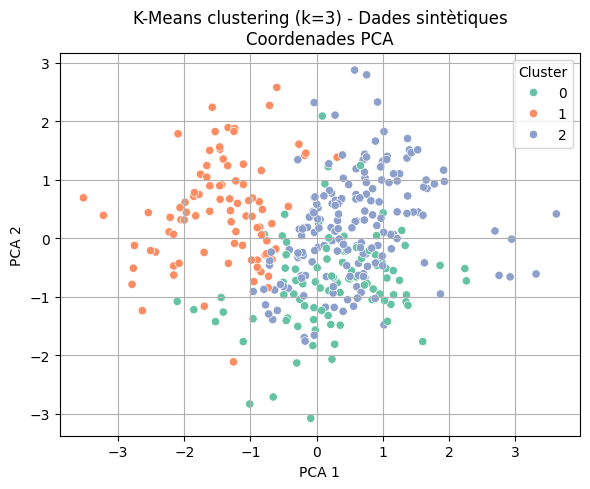

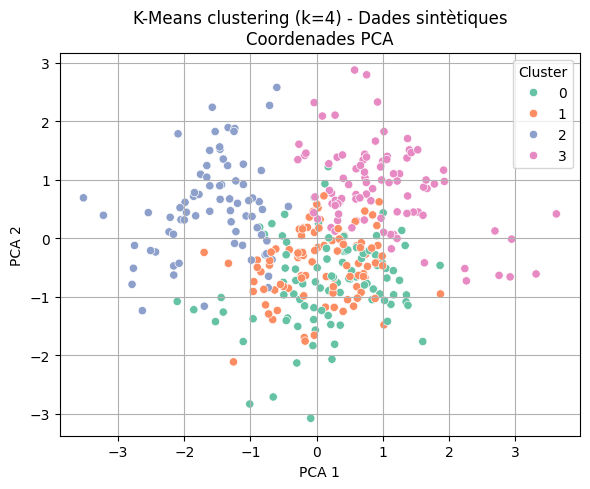

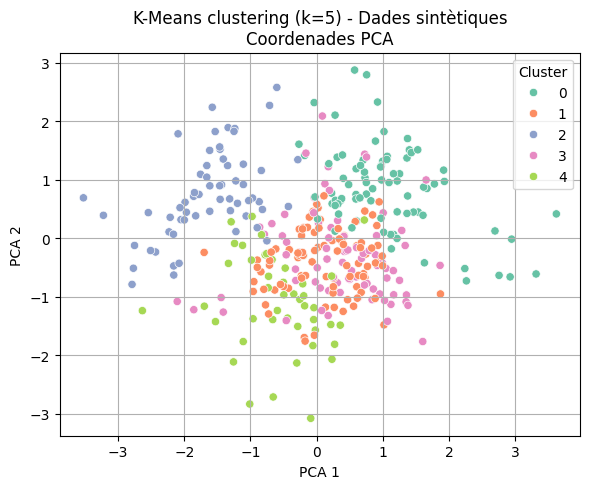

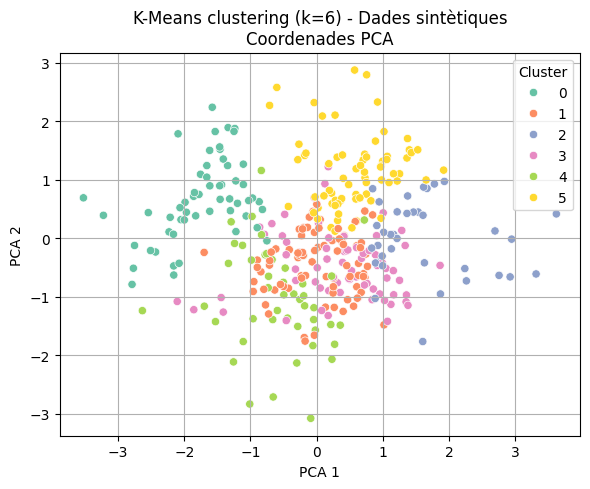

In [34]:
# Recalculem PCA
x_syn_pca = pca.fit_transform(x_synthetic)

# Provar amb k = 2 fins k = 6
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(x_synthetic)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=x_syn_pca[:, 0], y=x_syn_pca[:, 1], hue=clusters, palette='Set2', legend="full")
    plt.title(f"K-Means clustering (k={k}) - Dades sintètiques\nCoordenades PCA")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

En el cas de les dades sintètiques, podem observar que el que ha fet k-means ha sigut assignar a cada punt la classe que tingui el centroide més proper, però com hem vist a la projecció de PCA de l'apartat anterior, no podem concluir que aquestes dades tinguin prou capacitat de ser discriminades, i que les classes reals (que veiem a la gràfica del primer apartat) estàn separades amb molt poca claretat.

### • Agglomerative Hierarchical Clustering (AHC)

### • Autoencoder


### • Self-Organizing Maps (SOM)
